# Simple Transformer

+ Implement a simple Transformer model for time-series forecasting. 
+ Use Proloaf functions to manage data, training, evaluation etc.
+ Identify the key functions proloaf needs to incorporate this architecture 



### Scource 

https://medium.com/mlearning-ai/transformer-implementation-for-time-series-forecasting-a9db2db5c820

https://github.com/nklingen/Transformer-Time-Series-Forecasting/blob/main/train_with_sampling.py

## Load and Prepare Data

In [1]:
%run ../src/preprocess.py -s opsd

Importing CSV Data...
Importing time_series/2020-10-06/time_series_60min_singleindex.csv ...
...Importing finished. 
Importing weather_data/2020-09-16/weather_data.csv ...
...Importing finished. 
Some values are NaN. They are being filled...
...interpolation finished! No missing data left.
                     AT_load_actual_entsoe_transparency  \
Time                                                      
2014-12-31 23:00:00                              5946.0   
2015-01-01 00:00:00                              5946.0   
2015-01-01 01:00:00                              5726.0   
2015-01-01 02:00:00                              5347.0   
2015-01-01 03:00:00                              5249.0   
...                                                 ...   
2020-09-30 19:00:00                              6661.0   
2020-09-30 20:00:00                              6336.0   
2020-09-30 21:00:00                              5932.0   
2020-09-30 22:00:00                              5628.0   
2

[350640 rows x 6 columns]]
No missing data 



In [2]:
import proloaf as plf
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
MAIN_PATH = os.path.dirname(os.path.abspath(''))
PAR = plf.confighandler.read_config(model_name='opsd', config_path=None, main_path=MAIN_PATH)

### Add Cyclical Weekday Feature

+ proloaf needs cylical weekday features

In [4]:
df['weekday_sin'] = np.sin((df.index.weekday) * (2.0 * np.pi / 7))
df['weekday_cos'] = np.cos((df.index.weekday) * (2.0 * np.pi / 7))

<AxesSubplot:xlabel='Time'>

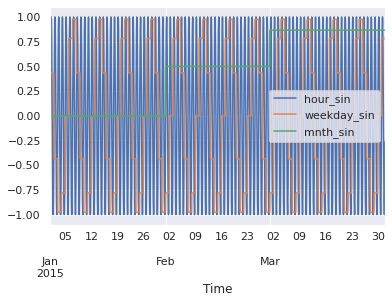

In [5]:
df.loc['2015-01':'2015-03', ['hour_sin', 'weekday_sin', 'mnth_sin']].plot()

<AxesSubplot:xlabel='Time'>

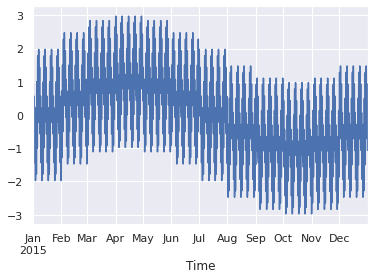

In [6]:
df[['hour_sin', 'weekday_sin', 'mnth_sin']].sum(axis=1).loc['2015'].plot()

<AxesSubplot:xlabel='Time'>

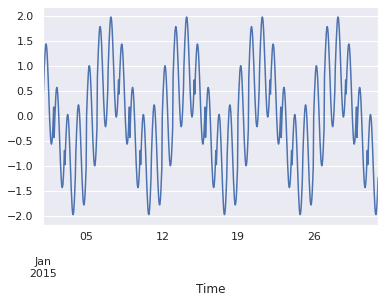

In [7]:
df[['hour_sin', 'weekday_sin', 'mnth_sin']].sum(axis=1).loc['2015-01'].plot()

+ alle zyklischen Features als Summe skalliert könnten ein gutes Time Embedding sein.

## Check Data 

In [8]:
plf.datahandler.check_continuity(df)

In [9]:
plf.datahandler.check_nans(df)

No missing data 



## Drop unnecessary columns

In [10]:
df.drop(labels=['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6'], axis=1, inplace=True)

In [30]:
PAR['encoder_features'] = ['AT_load_actual_entsoe_transparency',
                           'DE_load_actual_entsoe_transparency', 
                           'AT_temperature', 
                           'hour_sin', 'weekday_sin', 'mnth_sin']

PAR['decoder_features'] = [
    'DE_load_actual_entsoe_transparency', 
    'AT_temperature', 
    'hour_sin','weekday_sin', 'mnth_sin']

## Scale Features

In [32]:
PAR['feature_groups'][1]['features'] = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'mnth_sin', 'mnth_cos']

In [33]:
selected_features, scalers = plf.datahandler.scale_all(df, **PAR)

In [34]:
selected_features.head()

,AT_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,hour_sin,hour_cos,weekday_sin,weekday_cos,mnth_sin,mnth_cos
Time,,,,,,,,,,,,,,
2014-12-31 23:00:00,0.041917,-0.574240,-0.557967,-1.0,-1.0,-0.512260,-1.0,-1.0,-0.258819,0.965926,0.974928,-0.222521,-0.5,0.866025
2015-01-01 00:00:00,0.041917,-0.574240,-0.558285,-1.0,-1.0,-0.513962,-1.0,-1.0,0.000000,1.000000,0.433884,-0.900969,0.0,1.000000
2015-01-01 01:00:00,-0.001479,-0.618183,-0.556494,-1.0,-1.0,-0.516205,-1.0,-1.0,0.258819,0.965926,0.433884,-0.900969,0.0,1.000000
2015-01-01 02:00:00,-0.076240,-0.662688,-0.548331,-1.0,-1.0,-0.519277,-1.0,-1.0,0.500000,0.866025,0.433884,-0.900969,0.0,1.000000
2015-01-01 03:00:00,-0.095572,-0.677436,-0.534593,-1.0,-1.0,-0.521644,-1.0,-1.0,0.707107,0.707107,0.433884,-0.900969,0.0,1.000000


## Load Data in Tansors

In [35]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
    if PAR['cuda_id'] is not None:
        torch.cuda.set_device(PAR['cuda_id'])
else:
    DEVICE

In [36]:
train_dl, validation_dl, test_dl = plf.transform(selected_features, device=DEVICE, **PAR)

Size training set: 	26295
Size validation set: 	8765


## Define Transformer Model

In [17]:
class Transformer(nn.Module):
    def __init__(self,feature_size=6,num_layers=3,dropout=0):
        super(Transformer, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=3, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, inputs, device):
        mask = self._generate_square_subsequent_mask(len(inputs[1])).to(device)
        output = self.transformer_encoder(inputs, mask)
        output = self.decoder(output)
        return output

## Define Training

### Simple Training 


In [18]:
def transformer_training(dataloader, model, EPOCH, path_to_save_model=None, path_to_save_loss=None, path_to_save_predictions=None, device='cpu'):
    device = torch.device(device)
    
    if model == None:
        model = Transformer().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    best_model = ''
    min_train_loss = float('inf')
    
    for epoch in range(EPOCH + 1):
        
        train_loss = 0
        val_loss = 0
        
        model.train()
        for encoder_input, decoder_input, target in dataloader:
            
            optimizer.zero_grad()
                                         
            model_input = torch.concat((encoder_input, decoder_input), dim=1)
            
            prediction = model(model_input, device)
                                         
            loss = criterion(prediction[:, -len(decoder_input[0]):,:], target)
                                         
            loss.backward()
            optimizer.step()
                                         
            train_loss += loss.detach().item()
            
        if train_loss < min_train_loss:
            
            min_train_loss = train_loss
            best_model = f'best_train_{epoch}.pth'
        
        print(f'Epoch {epoch}\t train_loss {train_loss}\t')
        
    return best_model

In [19]:
PAR.get('encoder_features')

['AT_load_actual_entsoe_transparency',
 'DE_load_actual_entsoe_transparency',
 'AT_temperature',
 'hour_sin',
 'weekday_sin',
 'mnth_sin']

In [84]:
model = Transformer().to(DEVICE)
transformer_training(train_dl, model, 15, device=DEVICE)

Epoch 0	 train_loss 6.307177497074008	
Epoch 1	 train_loss 0.7359164006775245	
Epoch 2	 train_loss 0.5387760746234562	
Epoch 3	 train_loss 0.4490358504699543	
Epoch 4	 train_loss 0.3813229341758415	
Epoch 5	 train_loss 0.33143125819333363	
Epoch 6	 train_loss 0.2918337900628103	
Epoch 7	 train_loss 0.26493726554326713	
Epoch 8	 train_loss 0.23439350229455158	
Epoch 9	 train_loss 0.22180176559777465	
Epoch 10	 train_loss 0.1974820015966543	
Epoch 11	 train_loss 0.18413778745161835	
Epoch 12	 train_loss 0.16843631564552197	
Epoch 13	 train_loss 0.15767470173886977	
Epoch 14	 train_loss 0.15457777970732423	
Epoch 15	 train_loss 0.13712597668200033	


'best_train_15.pth'

## Prediction

In [85]:
def predict(model, encoder_input, decoder_input, device, forecast_window):
    predictions = []
    
    with torch.no_grad():
        model.eval()
        
        next_input = encoder_input 
        decoder_input = decoder_input[:,:,1:]
        
        for step in range(forecast_window):
                
            prediction = model(next_input, device)
            
            if predictions == []:
                predictions = prediction
            else:
                predictions = torch.cat((predictions, prediction[:, -1:, :]), 1)
                
            add_to_input = torch.cat((prediction[:,-1:,:], decoder_input[:,step:step+1,:]), 2)
            next_input = torch.cat((next_input, add_to_input), 1)
            
    return predictions 
        
def batch_predict(model, dataloader, device, forecast_window):
    batch_predictions = []
    
    for encoder_input, decoder_input, target in dataloader:
        
        prediction = predict(model, encoder_input, decoder_input, device, forecast_window)
        
        if batch_predictions == []:
            batch_predictions = prediction.unsqueeze(0)
        else:
            batch_predictions = torch.cat((batch_predictions, prediction.unsqueeze(0)), 0)
        
    return batch_predicitons
        

In [125]:
#prediction = batch_predict(model, train_dl, DEVICE, PAR['forecast_horizon'])
train_enc, train_dec, train_target = train_dl[10]
test_enc, test_dec, test_target = validation_dl[10]

train_prediction = predict(model, train_enc, train_dec, DEVICE, PAR['forecast_horizon'])
test_prediction = predict(model, test_enc, test_dec, DEVICE, PAR['forecast_horizon'])

## Plot Predictions 

In [26]:
def plot_prediction(model_input, target, prediction, prediction_num=0, figsize=(8, 6)):
    history_horizon = model_input.shape[1]
    forecast_hotizon = target.shape[1]
    
    past_values = model_input[prediction_num, :, 0].cpu().detach().numpy().reshape(-1, 1)
    target = target[prediction_num,:,:].cpu().detach().numpy()
    prediction = prediction[prediction_num, :, :].cpu().detach().numpy()
    
    plt.figure(figsize=figsize)
    plt.plot(range(history_horizon), past_values, label='past')
    plt.plot(range(history_horizon, forecast_hotizon+history_horizon), target, label='target')
    plt.plot(range(1, history_horizon+forecast_hotizon), prediction, label='prediction')
    plt.legend()
    plt.title('Prdiction')
    plt.xlabel('Time Step')
    plt.ylabel('Load')
    plt.show()

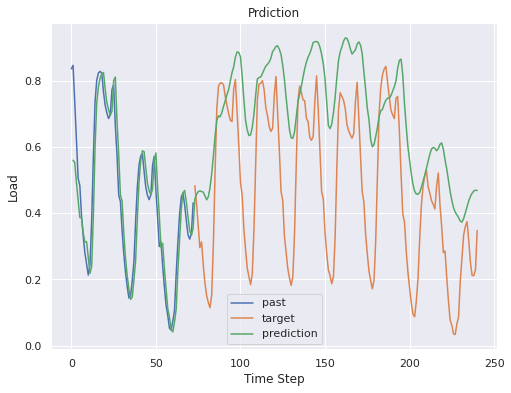

In [149]:
plot_prediction(train_enc, train_target, train_prediction, prediction_num=0)

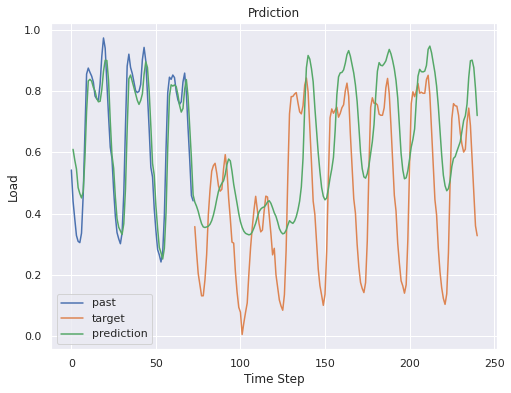

In [146]:
plot_prediction(test_enc, test_target, test_prediction, prediction_num=31)

## Save & Load Model

In [102]:
torch.save(model.state_dict(), 'model.pth')

In [111]:
model = Transformer()
model.load_state_dict(torch.load('model.pth'))
model.to(DEVICE)

Transformer(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
    )
    (linear1): Linear(in_features=6, out_features=2048, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (linear2): Linear(in_features=2048, out_features=6, bias=True)
    (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=2048, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features

# Simple Transformer adjusted for ProLoaF Project

## init function

+ added parameters --> features_size, num_layers, dropout, forecast_horizon, n_heads()
+ added forecast_horizon attribute

## forward function

+ inputs are the same as in ProLoaF --> encoder_inputs, decoder_inputs
+ decoder_inputs werden mit einem Nullvektor für target Spalte erweitert
+ encoder_inputs und erweiterte decoder_inputs werden zusammengeführt shape(batch_size, history_horizon+forecast_horizon, feature_size)
+ maske wird für den forecast generiert
+ attention und output werden ausgerechnet und ausgegeben
    + output wird nur der relevante Bereich des forecast_horizons ausgegeben (output[:, -forecast_horizon:,:])
+ forward function ist nun in der Lage alle Zeitschritte auf einmal auszurechnen --> es muss nicht mehr wiederkehrend ausgeführt werden

## Verbesserungsmöglichkeiten

+ Zeitliche Features zum Target dazuaddieren, um Dimensionen zu sparen?
+ sin und cos Features hinzufügen?
+ One-Hot-Encoded Features ausprobieren?


## Functions

In [17]:
class Transformer2(nn.Module):
    def __init__(self,
                 feature_size: int,
                 num_layers: int=3,
                 dropout: float=0.0,
                 forecast_horizon: float=1,
                 n_heads: int=6,
                 ):
        super(Transformer2, self).__init__()
        
        self.forecast_horizon = forecast_horizon
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=n_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, inputs_encoder, inputs_decoder, device='cuda'):
        
        inputs_decoder = torch.cat((torch.zeros(inputs_decoder.shape[0], self.forecast_horizon, 1).to(device), inputs_decoder),2).to(device)
        inputs = torch.cat((inputs_encoder, inputs_decoder), 1).to(device)
        
        mask = self._generate_square_subsequent_mask(inputs.shape[1]).to(device)
        
        attention = self.transformer_encoder(inputs, mask)
        output = self.decoder(attention)
        
        return output[:, -self.forecast_horizon:, :], attention

In [18]:
def transformer_training2(dataloader, model, EPOCH, path_to_save_model=None, path_to_save_loss=None, path_to_save_predictions=None, device='cpu'):
    device = torch.device(device)
    
    if model == None:
        model = Transformer2().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    best_model = ''
    min_train_loss = float('inf')
    
    for epoch in range(EPOCH + 1):
        
        train_loss = 0
        val_loss = 0
        
        model.train()
        for encoder_input, decoder_input, target in dataloader:
            
            optimizer.zero_grad()
            
            prediction, _ = model(encoder_input, decoder_input)
                                         
            loss = criterion(prediction[:, -len(decoder_input[0]):,:], target)
                                         
            loss.backward()
            optimizer.step()
                                         
            train_loss += loss.detach().item()
            
        if train_loss < min_train_loss:
            
            min_train_loss = train_loss
            best_model = f'best_train_{epoch}.pth'
        
        print(f'Epoch {epoch}\t train_loss {train_loss}\t')
        
    return best_model

In [19]:
def plot_prediction2(model_input, target, prediction, prediction_num=0, figsize=(8, 6)):
    history_horizon = model_input.shape[1]
    forecast_hotizon = target.shape[1]
    
    past_values = model_input[prediction_num, :, 0].cpu().detach().numpy().reshape(-1, 1)
    target = target[prediction_num,:,:].cpu().detach().numpy()
    prediction = prediction[prediction_num, :, :].cpu().detach().numpy()
    
    plt.figure(figsize=figsize)
    plt.plot(range(history_horizon), past_values, label='past')
    plt.plot(range(history_horizon, forecast_hotizon+history_horizon), target, label='target')
    plt.plot(range(history_horizon, forecast_hotizon+history_horizon), prediction, label='prediction')
    plt.legend()
    plt.title('Prdiction')
    plt.xlabel('Time Step')
    plt.ylabel('Load')
    plt.show()

In [20]:
def plot_attention(attention, features=PAR['encoder_features'], prediction_num=0, figsize=(10, 8)):
    horizon = attention.shape[1]
    attention = attention[prediction_num,:,:].cpu().detach().numpy()
    
    df = pd.DataFrame(data=attention, columns=features)
#     print(df[features])
    plt.figure(figsize=figsize)

    df.plot(kind='line', figsize=figsize, title='Attention Values per Feature', legend=False)
    plt.xlabel('Step')
    plt.ylabel('Attention')
    
    plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
    plt.show

## Training, Predicitons & Plots

In [24]:
model2 = Transformer2(feature_size=5, num_layers=3, dropout=0.0, forecast_horizon=168, n_heads=5).to(DEVICE)
transformer_training2(train_dl, model2, EPOCH=15, device=DEVICE)

Epoch 0	 train_loss 29.92255021445453	
Epoch 1	 train_loss 13.186450637876987	
Epoch 2	 train_loss 11.558325722347945	
Epoch 3	 train_loss 10.959148697555065	
Epoch 4	 train_loss 10.461245198734105	
Epoch 5	 train_loss 10.21118521457538	
Epoch 6	 train_loss 9.881332300137728	
Epoch 7	 train_loss 9.758831033483148	
Epoch 8	 train_loss 9.522661081515253	
Epoch 9	 train_loss 9.247272385284305	
Epoch 10	 train_loss 9.126819727476686	
Epoch 11	 train_loss 8.971141635905951	
Epoch 12	 train_loss 8.865098027512431	
Epoch 13	 train_loss 8.69932187302038	
Epoch 14	 train_loss 8.660045725293458	
Epoch 15	 train_loss 8.476884520146996	


'best_train_15.pth'

In [38]:
train_enc, train_dec, train_target = train_dl[0]
test_enc, test_dec, test_target = validation_dl[0]

train_prediction, train_ = model2(train_enc, train_dec)
test_prediction, test_ = model2(test_enc, test_dec)

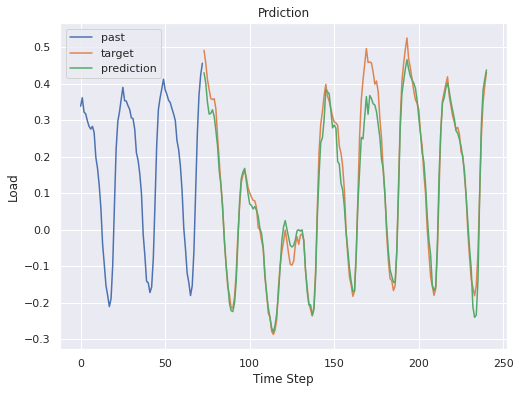

In [39]:
plot_prediction2(train_enc, train_target, train_prediction, prediction_num=0)

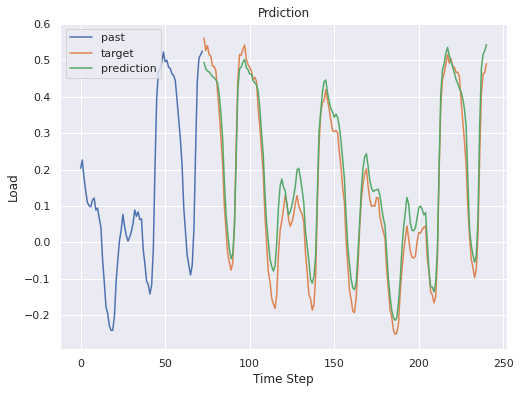

In [42]:
plot_prediction2(test_enc, test_target, test_prediction, prediction_num=20)

<Figure size 720x576 with 0 Axes>

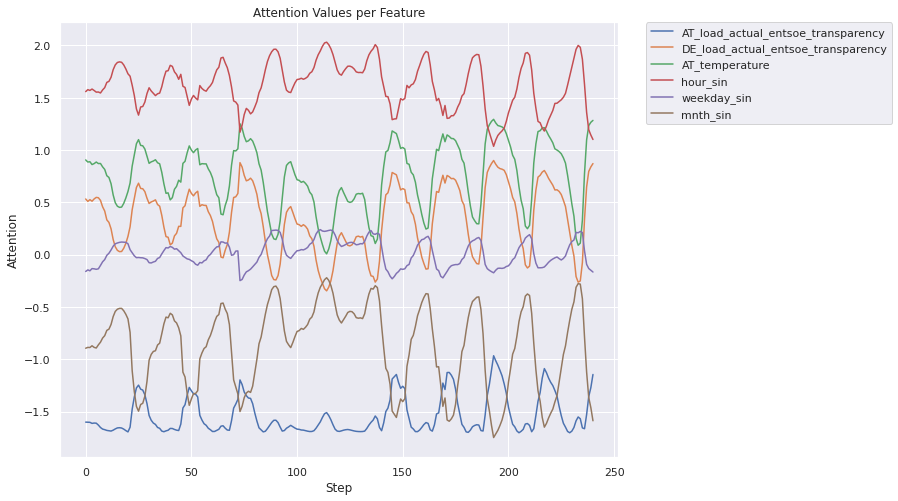

In [43]:
plot_attention(train_, features=PAR['encoder_features'], prediction_num=0)

<Figure size 720x576 with 0 Axes>

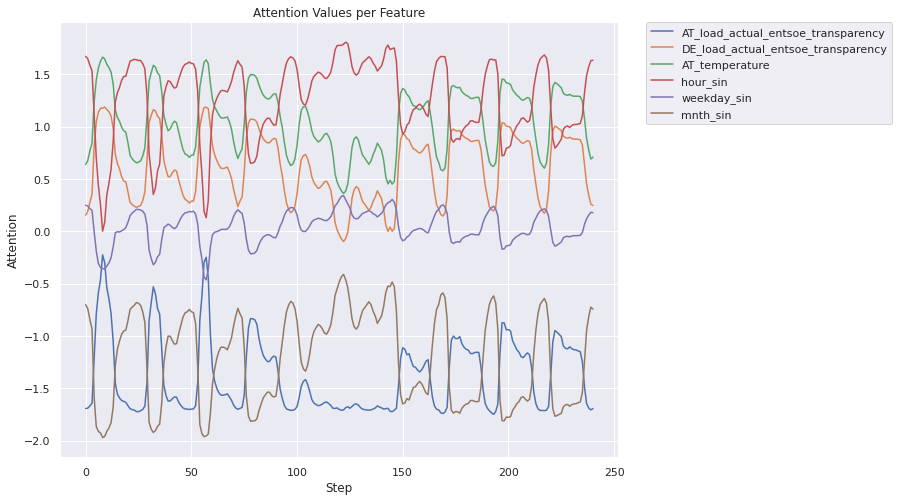

In [44]:
plot_attention(test_, features=PAR['encoder_features'], prediction_num=0)

## Save & Load Model

In [154]:
torch.save(model2.state_dict(), 'model2.pth')

In [37]:
model2 = Transformer2(feature_size=6, num_layers=3, dropout=0.0, forecast_horizon=168, n_heads=6)
model2.load_state_dict(torch.load('model2.pth'))
model2.to(DEVICE)

Transformer2(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
    )
    (linear1): Linear(in_features=6, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=2048, out_features=6, bias=True)
    (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in